In [14]:
import pandas as pd
import ast
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [15]:
# Step 1: Data Preprocessing
file_path = 'C:/Users/issam_biodcm6/Documents/CS582 Assignments/end-of-semester-project/data/processed_data/combined_data.csv'
d = pd.read_csv(file_path)
d.head(5)


,Elevation,Azimuth,ITD,ILD,Spectral ILD,Spectral ITD,Left MFCC,Right MFCC
0,-10,0,[-0.00292517 -0.01018141],[0.266732 0.93314514],[0.2690964 0.2775728],[-0.01160998 -0.00580499 0. ],[[-199.90599 -251.3258 ]\n [ -9.529352 ...,[[-2.0854100e+02 -2.6012430e+02]\n [ 1.2185602...
1,-10,5,[-0.00287982 -0.01018141],[-1.47343338 0.42903516],[-1.5182811 -0.85201576],[-0.01160998 -0.00580499 0. ],[[-209.85387 -261.09167 ]\n [ -4.1136837...,[[-199.50696 -251.42146 ]\n [ 7.477209 ...
2,-10,10,[-0.00283447 -0.01179138],[-3.15547019 0.23635436],[-3.24823767 -1.9387275 ],[-0.00580499 -0.00580499 -0.00580499],[[-220.29958 -270.83414 ]\n [ 1.1125026 ...,[[-191.27338 -243.33148 ]\n [ 3.3398633...
3,-10,15,[-0.00278912 -0.01179138],[-4.76506531 0.9634611 ],[-4.90409791 -3.00950706],[-0.01160998 -0.00580499 0.00580499],[[-230.81404 -281.11288 ]\n [ 7.301242 ...,[[-184.50407 -236.86351 ]\n [ 0.840785 ...
4,-10,20,[-0.00276644 -0.01176871],[-6.18944943 1.88572168],[-6.37494266 -3.96631181],[-0.01160998 0. 0. ],[[-2.41548431e+02 -2.91211823e+02]\n [ 1.33940...,[[-179.76869 -232.35434 ]\n [ 1.0394747 ...


In [17]:
# Convert string arrays to numeric arrays
def parse_array_string(array_string):
    # Remove brackets and split by whitespace
    array_string = array_string.strip('[]')
    array_values = array_string.split()

    # Convert values to float
    numeric_array = [float(value) for value in array_values]
    return numeric_array

# Convert string arrays to numeric arrays in the dataset
for col in ['ITD', 'ILD', 'Spectral ILD', 'Spectral ITD']:
    d[col] = d[col].apply(parse_array_string)

# Convert lists to pandas Series of numeric values
for col in ['ITD', 'ILD', 'Spectral ILD', 'Spectral ITD']:
    temp_df = pd.DataFrame(d[col].to_list(), columns=[f"{col}_{i}" for i in range(len(d[col].iloc[0]))])
    d = pd.concat([d, temp_df], axis=1)
    d.drop(columns=[col], inplace=True)

# Separate features (X) and target (y)
X = d.drop(columns=['Azimuth'])  # Features: Elevation, ITD, ILD, Spectral ILD, Spectral ITD
y = d['Azimuth']  # Target: Azimuth

print(X.dtypes)


X.head()


Elevation           int64
ITD_0             float64
ITD_1             float64
ILD_0             float64
ILD_1             float64
Spectral ILD_0    float64
Spectral ILD_1    float64
Spectral ITD_0    float64
Spectral ITD_1    float64
Spectral ITD_2    float64
dtype: object


,Elevation,ITD_0,ITD_1,ILD_0,ILD_1,Spectral ILD_0,Spectral ILD_1,Spectral ITD_0,Spectral ITD_1,Spectral ITD_2
0,-10,-0.002925,-0.010181,0.266732,0.933145,0.269096,0.277573,-0.011610,-0.005805,0.000000
1,-10,-0.002880,-0.010181,-1.473433,0.429035,-1.518281,-0.852016,-0.011610,-0.005805,0.000000
2,-10,-0.002834,-0.011791,-3.155470,0.236354,-3.248238,-1.938727,-0.005805,-0.005805,-0.005805
3,-10,-0.002789,-0.011791,-4.765065,0.963461,-4.904098,-3.009507,-0.011610,-0.005805,0.005805
4,-10,-0.002766,-0.011769,-6.189449,1.885722,-6.374943,-3.966312,-0.011610,0.000000,0.000000


In [18]:
# Separate features (X) and target (y)
X = d.drop(columns=['Azimuth', 'Elevation'])  # Features: ITD, ILD, Spectral ILD, Spectral ITD
y = d['Azimuth']  # Target: Azimuth

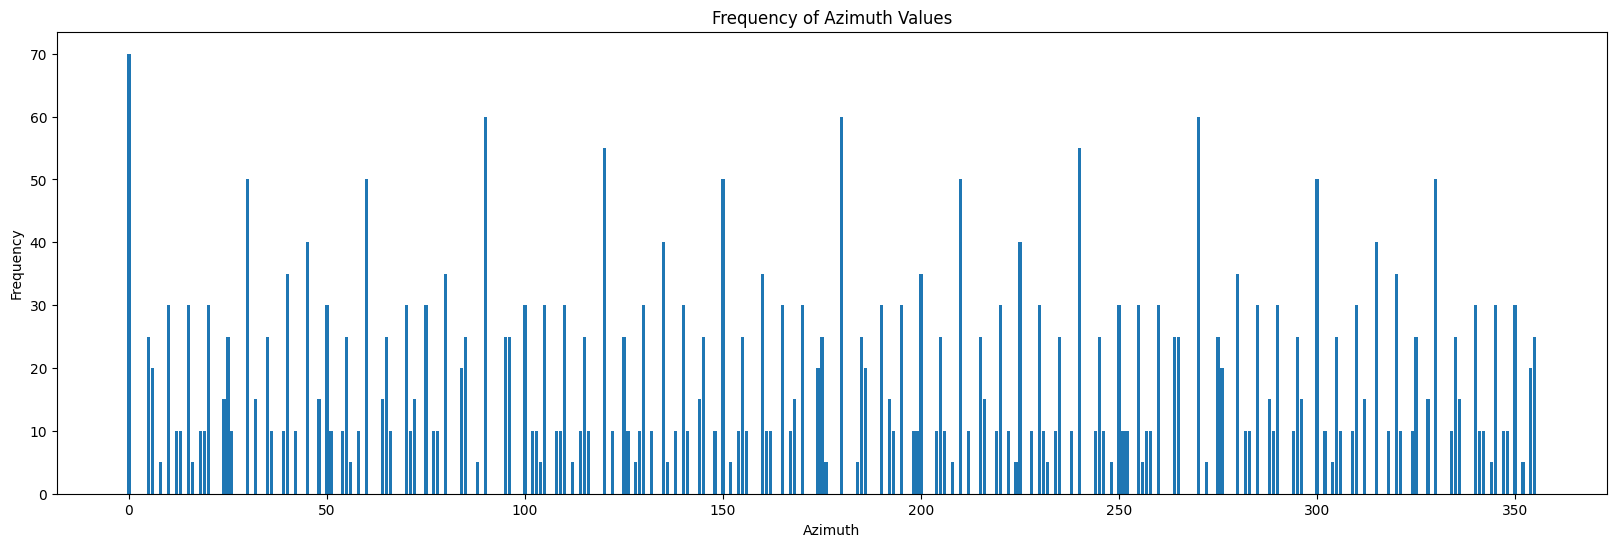

In [19]:
y.head()
# Calculate frequencies of azimuth values
azimuth_freq = y.value_counts().sort_index()
# Set figure size
plt.figure(figsize=(20, 6))
# Plot the frequencies
plt.bar(azimuth_freq.index, azimuth_freq.values)
plt.xlabel('Azimuth')
plt.ylabel('Frequency')
plt.title('Frequency of Azimuth Values')
plt.show()




In [20]:
# Step 2: Split the data into train, tune, and test sets
# We'll split the data into 70% training, 15% tuning, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=4)
X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)

In [21]:
# Step 3: Train a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=4)

In [22]:
# Step 4: Tune hyperparameters using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

# Step 5: Evaluate the model on the tuning set
best_rf_classifier = grid_search.best_estimator_
tune_predictions = best_rf_classifier.predict(X_tune)
tune_accuracy = accuracy_score(y_tune, tune_predictions)
print("Tuning set accuracy:", tune_accuracy)


c:\Users\issam_biodcm6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuning set accuracy: 0.981203007518797


In [23]:
# Step 6: Evaluate the model on the test set
test_predictions = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test set accuracy:", test_accuracy)


Test set accuracy: 0.9906191369606003


In [25]:
import pandas as pd

# Extract test azimuth cases and predicted values
test_azimuth_cases = y_test # Replace <index_of_azimuth_column> with the index of the azimuth column in your feature matrix X_test
predicted_test_azimuth_values = test_predictions

# Create a DataFrame to store the data
results_df = pd.DataFrame({'Test Azimuth Cases': test_azimuth_cases, 'Predicted Azimuth Values': predicted_test_azimuth_values})

# Save DataFrame to a CSV file
results_df.to_csv('test_results.csv', index=False)
